In [1]:
import numpy as np
import json
import itertools

In [2]:
## We import the T/I group acting on pitch classes from Opycleid

from opycleid.musicmonoids import TI_Group_PC

TI_group = TI_Group_PC()

## Additionally, we need a dictionary translating pitch class numbers to pitch class names

dict_pc_to_name = {9:'A', 0:'C', 11:'B', 4:'E', 2:'D', 7:'G', 5:'F',
                    6:'Fs', 8:'Gs', 10:'Bb', 3:'Eb', 1:'Cs'}

In [3]:
## We load the JSON containing the data for Webern's Op. 11/2

wbrn_data = json.loads(open("./wbrn_11_2.json").read())

list_notes = [x+[y] for y in ["cello","piano_RH","piano_LH"] for x in wbrn_data[y]]

## We sort the notes by their time...
note_times = sorted(list(set([x[1] for x in list_notes])))
## ... and create a dictionary of note orders
note_order = dict(zip(note_times,range(len(note_times))))

## This new structure will be easier to manipulate
list_notes_dict = {}
for i,x in enumerate(list_notes):
    temp_dict = {"pc":x[0],"pc_name":dict_pc_to_name[x[0]],
                 "t":x[1],"d":x[2],"x_score":x[3],"y_score":x[4],
                 "part":x[5],"order":note_order[x[1]]}
    list_notes_dict[i]=temp_dict

In [7]:
## We create the global matrix of transitions between notes

N_notes = len(list_notes_dict.keys())
N_operations = len(TI_group.operations.keys())

## This is a (N_notes,N_notes,N_operations) matrix,
## where cell (i,j,k) is equal to 1 if operation k takes note i to note j

dict_op2opidx = dict(zip(TI_group.operations.keys(),range(len(TI_group.operations.keys()))))
dict_opidx2op = dict(zip(range(len(TI_group.operations.keys())),TI_group.operations.keys()))
operations_table = np.zeros((N_notes,N_notes,N_operations))

for i in range(N_notes):
    for j in range(N_notes):
        op = TI_group.get_operation(list_notes_dict[i]["pc_name"],list_notes_dict[j]["pc_name"])
        for x in op:
            operations_table[j,i,dict_op2opidx[x]]=1

In [8]:
## This generator allows to enumerate all Klumpenhouwer networks, given a path of transformations
## For example, if one wants to find the networks of path o --(T^3)--> o --(I^9)--> o
## one would then enumerate over get_pknets(["T^3","I^9"])

def get_pknets(operations,note=None,curpath=[]):
    if note==None:
        final_paths = []
        for i in range(N_notes):
            for path in get_pknets(operations,note=i,curpath=[i]):
                yield path
    else:
        if len(operations)==0:
            yield curpath
        else:
            next_notes = np.where(operations_table[:,note,dict_op2opidx[operations[0]]])[0]
            for i in next_notes:
                for path in get_pknets(operations[1:],note=i,curpath=curpath+[i]):
                    yield path

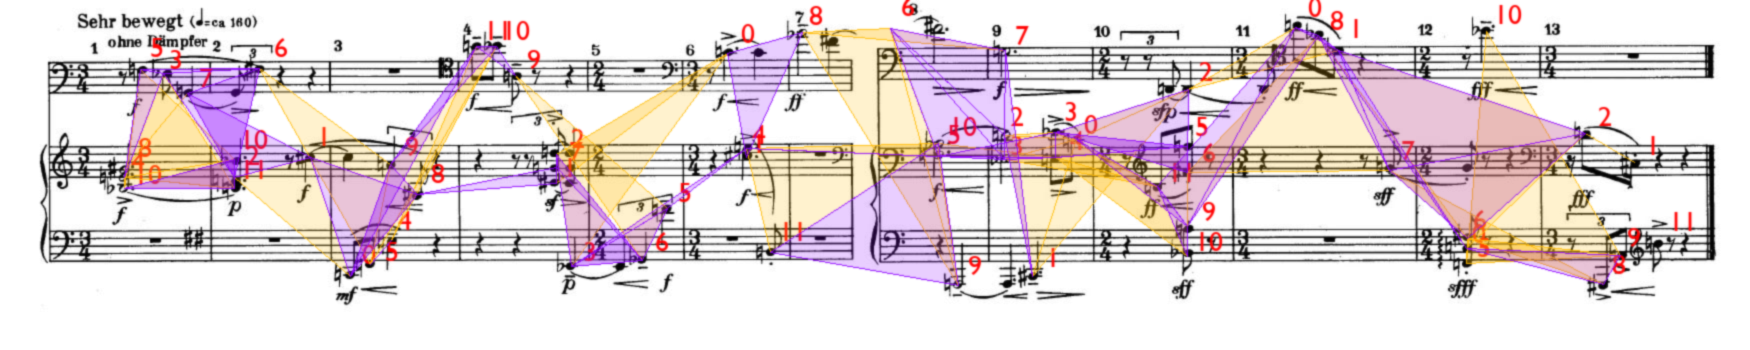

In [9]:
from PIL import Image,ImageDraw, ImageFont, ImageFilter

im = Image.open("./wbrn_11_2.jpg")
draw = ImageDraw.Draw(im,mode="RGBA")
the_font = ImageFont.truetype("./GillSans.ttf", 28)

## Utility function for ordering coordinates,
## so that the corresponding polygon is nicely drawn

def order_points(points):
    center = [np.mean([x[0] for x in points]),np.mean([x[1] for x in points])]
    vect = [(x[0]-center[0],x[1]-center[1]) for x in points]
    #unit_vect = [x/np.linalg.norm(x) for x in vect]
    angles = [np.angle(x[0]+1j*x[1]) for x in vect]
    return [x for _,x in sorted(zip(angles,points))]

## We draw the pitch class numbers for each note

the_color=(255,0,0,0)
for i,note in list_notes_dict.items():
    draw.text((note["x_score"]+6+np.random.randint(10),note["y_score"]-26-np.random.randint(10)),
              str(note["pc"]), fill=the_color, font=the_font)

## We will display the networks of paths o --(T^1)--> o --(I^3)--> o
## and o --(T^1)--> o --(I^9)--> o
## such that the notes are not further than 4 steps apart
    
pknet_types = [[(255,187,5,50),["T^1","I^3"]],
               [(142,5,255,50),["T^1","I^9"]]]
  
for the_color,the_type in pknet_types:  
    for notes in get_pknets(the_type):
        orders = [list_notes_dict[u]["order"] for u in notes]
        if np.max(orders)-np.min(orders)<=4.0:
            list_coord = [(list_notes_dict[u]["x_score"],list_notes_dict[u]["y_score"]) for u in notes]
            list_coord = order_points(list_coord)
            list_coord.append(list_coord[0]) ## Close the drawing

            draw.polygon(list_coord, fill=the_color)
            draw.line([u for c in list_coord for u in c], fill=(the_color[0],the_color[1],the_color[2]))
im = im.filter(ImageFilter.GaussianBlur(radius=0.8))
im